### **GAN with MNIST Dataset**

**Imports**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torchvision import transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display

**Parameters**

In [ ]:
criterion=nn.BCEWithLogitsLoss() #Equivalent to: tf.keras.losses.BinaryCrossentropy(from_logits=True)
epochs=200
z_dim=64
batch_size=128
lr=0.00001
device="cuda"
display_step=500

**Build the model**

In [ ]:
class Generator(nn.Module):

  def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
    super().__init__()

    self.generator = nn.Sequential(
        self.generator_block(z_dim, hidden_dim),
        self.generator_block(hidden_dim, hidden_dim*2),
        self.generator_block(hidden_dim*2, hidden_dim*4),
        self.generator_block(hidden_dim*4, hidden_dim*8),
        nn.Linear(hidden_dim*8, im_dim),
        nn.Sigmoid()
    )

  def generator_block(self, input_shape, output_shape):
    return nn.Sequential(
        nn.Linear(input_shape, output_shape),
        nn.BatchNorm1d(output_shape),
        nn.ReLU(inplace=True)
    )
    return model_block

  def forward(self, noise):
    return self.generator(noise)

In [ ]:
generator=Generator(z_dim).to(device)

In [ ]:
summary(generator, (z_dim, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           8,320
       BatchNorm1d-2                  [-1, 128]             256
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 256]          33,024
       BatchNorm1d-5                  [-1, 256]             512
              ReLU-6                  [-1, 256]               0
            Linear-7                  [-1, 512]         131,584
       BatchNorm1d-8                  [-1, 512]           1,024
              ReLU-9                  [-1, 512]               0
           Linear-10                 [-1, 1024]         525,312
      BatchNorm1d-11                 [-1, 1024]           2,048
             ReLU-12                 [-1, 1024]               0
           Linear-13                  [-1, 784]         803,600
          Sigmoid-14                  [

In [ ]:
class Discriminator(nn.Module):

  def __init__(self, im_dim=784, hidden_dim=128):
    super().__init__()

    self.discriminator=nn.Sequential(
        self.generator_block(im_dim, hidden_dim*4),
        self.generator_block(hidden_dim*4, hidden_dim*2),
        self.generator_block(hidden_dim*2, hidden_dim),
        nn.Linear(hidden_dim, 1)
    )

  def generator_block(self, input_shape, output_shape):

    model_block=nn.Sequential(
        nn.Linear(input_shape, output_shape),
        nn.LeakyReLU(0.2)
    )
    return model_block

  def forward(self, image):
    return self.discriminator(image)

In [ ]:
discriminator=Discriminator().to(device)

In [ ]:
summary(discriminator, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
         LeakyReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 256]         131,328
         LeakyReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
         LeakyReLU-6                  [-1, 128]               0
            Linear-7                    [-1, 1]             129
Total params: 566,273
Trainable params: 566,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.16
Estimated Total Size (MB): 2.18
----------------------------------------------------------------


**Load and Preprocess the Dataset**

In [ ]:
train_dataset=DataLoader(
    MNIST(".", transform=transforms.ToTensor(), download=True),
    batch_size=batch_size,
    shuffle=True)

In [ ]:
for im_examples, lb_examples in train_dataset:
  break

im_examples.shape, lb_examples.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [ ]:
im_examples.min(), im_examples.max()

(tensor(0.), tensor(1.))

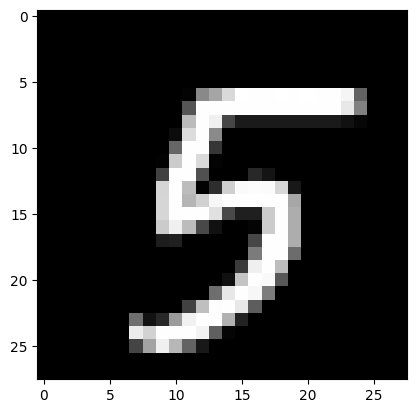

In [ ]:
plt.imshow(im_examples[0].permute(1, 2, 0), cmap="gray");

**Train the Model**

In [ ]:
gen_optimizer=torch.optim.Adam(generator.parameters(), lr=lr)
disc_optimizer=torch.optim.Adam(discriminator.parameters(), lr=lr)

In [ ]:
def show_images(real_images, fake_images, num_images=25, nrow=5, size=(1, 28, 28), cmap="gray"):

  real_images=real_images.cpu().view(-1, *size)
  real_images=make_grid(real_images[:num_images], nrow=nrow).permute(1, 2, 0)
  fake_images=fake_images.cpu().view(-1, *size)
  fake_images=make_grid(fake_images[:num_images], nrow=nrow).permute(1, 2, 0)

  fig, ax = plt.subplots(1, 2, figsize=(nrow*2, nrow*2))
  ax[0].imshow(fake_images, cmap=cmap)
  ax[0].axis("off")
  ax[0].set_title("Generated Images")

  ax[1].imshow(real_images, cmap=cmap)
  ax[1].axis("off")
  ax[1].set_title("Real Images")

  plt.show()

In [ ]:
def train_gan(epochs=50, display_wait=False):
  step=1
  mean_generator_loss=0
  mean_discriminator_loss=0

  for epoch in range(epochs):
    with tqdm(train_dataset) as pbar:
      pbar.set_description(f"[Epoch: {epoch+1}]")
      for batch_images, _ in pbar:
        cur_batch_size=len(batch_images)
        real_images=batch_images.view(cur_batch_size, -1).to(device)

        # Update discriminator
        disc_optimizer.zero_grad()
        noise=torch.randn(cur_batch_size, z_dim, device=device)
        fake_images=generator(noise).detach()
        fake_out=discriminator(fake_images)
        fake_loss=criterion(fake_out, torch.zeros_like(fake_out))

        real_out=discriminator(real_images)
        real_loss=criterion(real_out, torch.ones_like(real_out))

        disc_loss=(fake_loss+real_loss)/2
        disc_loss.backward(retain_graph=True)
        disc_optimizer.step()

        mean_discriminator_loss+=disc_loss.item()/display_step

        # Update Generator
        gen_optimizer.zero_grad()
        noise=torch.randn(cur_batch_size, z_dim, device=device)
        fake_images=generator(noise)
        fake_out=discriminator(fake_images)
        gen_loss=criterion(fake_out, torch.ones_like(fake_out))

        gen_loss.backward(retain_graph=True)
        gen_optimizer.step()

        mean_generator_loss+=gen_loss.item()/display_step

        #Visualization
        pbar.set_postfix({"Step": step, "gen_loss": gen_loss.item(), "disc_loss": disc_loss.item()})

        if step%display_step==0:
          display.clear_output(wait=display_wait)
          print(f"Epoch {epoch+1}, Step {step}: MeanGeneratorLoss: {mean_generator_loss}, MeanDiscriminatorLoss: {mean_discriminator_loss}")
          noise=torch.randn(cur_batch_size, z_dim, device=device)
          fake_images=generator(noise).detach()

          show_images(real_images, fake_images)

          mean_generator_loss=0
          mean_discriminator_loss=0

        step+=1

Epoch 200, Step 93500: MeanGeneratorLoss: 1.0513337982892992, MeanDiscriminatorLoss: 0.5653606485128403


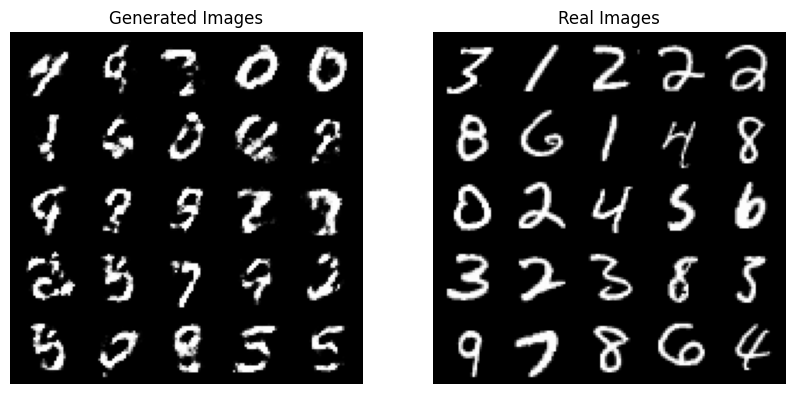

[Epoch: 200]: 100%|██████████| 469/469 [00:12<00:00, 36.78it/s, Step=93800, gen_loss=1.1, disc_loss=0.537]


In [ ]:
train_gan(epochs=epochs)